In [151]:
# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib
from collections import OrderedDict
import itertools
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter

import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

import copy

%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 16})

e0 = 8.854e-12

In [152]:
%store -r da_dv
%store -r da_bv
# %store -r da_sw
# %store -r da_dcs

da_dv = da_dv.load()

## Raw Delta V 

In [153]:
col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
row = None if (len(da_dv.indexes['direction']) == 1)  else 'direction'
timeslice = slice(0e-9,1000e-9)

## Interpolate the dark cavity sweep to match with the delta v data array

In [154]:
da_dcsi = da_bv.interp_like(da_dv,method = 'nearest')
v0s = da_dcsi

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


For now just pull out one freqt

## fitting setup

Define fit parameters

In [155]:
fittype = 'lor'
# fittype = 'lorline'
# fittype = 'poly'

if fittype == 'lor':
    Rinf = 0.02125
    f0 = None
    p0_default =[f0,0.01,Rinf,1e7]
    p_labels = ['f0','R0','Rinf','w'] 
    epsilon = 0.001 #problems with fixing R0 when this gets too smalll??? fit does not respond to bounds on R0 properly...
    window = 100
    samps = v0s.indexes['sample']
    Ks = pd.Series(index = samps) #Define only for lorentzian as poly fits need Ks
    fixR0 = True

if fittype == 'lorline':
    Rinf = 0.02125
    f0 = None
    w = 1e7
    p0_default =[f0,0.01,Rinf,w, 0.001/w, 0]
    p_labels = ['f0','R0','Rinf','w', 'm','b'] 
    epsilon = 0.001 #problems with fixing R0 when this gets too smalll??? fit does not respond to bounds on R0 properly...
    window = 100
    samps = v0s.indexes['sample']
    Ks = pd.Series(index = samps) #Define only for lorentzian as poly fits need Ks
    fixR0 = True
    
# TODO: need to pass out all covariance only happening for one lor fn
    
elif fittype == 'poly':
    window = 2
    p_labels = [ 'f0','R0', 'p0','p1','p2']
    bounds = ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
    p0_default = [.01,1e-9,1e-18]
    

def defaultbounds(fittype, fixR0, Rinf= Rinf):
    boundsdict = {
        'fixR0':{
            'lor' : ([0,0,Rinf - epsilon,0 ],[np.inf,np.inf,Rinf + epsilon,np.inf ]),
            'lorline': ([0,0,Rinf - epsilon,0 ,-np.inf,0],[np.inf,np.inf,Rinf + epsilon,np.inf ,np.inf,np.inf]),
            'poly': ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
        },
        'varyR0':{
            'lor' : ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf]),
            'lorline': ([0,0,0, 0,-np.inf,0-0.001],[np.inf,np.inf,np.inf, np.inf,np.inf,0+0.001]),
            'poly': ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
        }

    }
    
    if fixR0:
        return boundsdict['fixR0'][fittype]
    else:
        return boundsdict['varyR0'][fittype]

    
time1 = 0e-9
time2 = 1800e-9
timerange = slice(time1,time2)
timestep = 10e-9 #not index and has been moved inside for loop...need to check

# direcs = v0s.indexes['direction'].values
direcs = ['U']

samps = v0s.indexes['sample']
# samps = ['bia','bid']
flus = slice(-1,-2,-1)
# seldicts = list(analysis.dict_product({'sample' :samps, 'direction':direcs}))

seldicts = list(analysis.dict_product({'sample' :samps, 'direction':direcs, 'dist': v0s.indexes['dist']}))


Initialize data and perform fits

In [156]:
###Setup dictionaries to input paramters into
da_p = da_dv.isel(freq = 0).drop('freq').where(False).copy()
da_p0 = v0s.isel(freq = 0).drop('freq').where(False).copy()

da_p_dict = {}
da_p0_dict = {}
for p in p_labels:
    da_p_dict[p] = da_p
    da_p0_dict[p] = da_p0
    
#Not exactly sure why I have to do this copying. Otherwise I think the reference to the original numpy array is kept and assignments get all weird
ds_p = xr.Dataset(da_p_dict).copy(deep=True)
ds_p0 = xr.Dataset(da_p0_dict).copy(deep=True)

ds_p_r  =  ds_p.sel(time = timerange).copy(deep = True).where(False)   #nessecary, subselection is currently not done for ds_p0
ds_cov_r  =  ds_p.sel(time = timerange).copy(deep = True).where(False)   #nessecary, subselection is currently not done for ds_p0


###Generate Vshift data array
dvs = da_dv.sel(time = timerange)
vss = v0s + dvs

###Create data arrays to put fits into
fits_v0 = v0s.copy(deep= True).where(False)
fits = dvs.copy(deep = True).where(False)

#numer of fits for percent indicator, not working. 
num = len(seldicts)*(abs(flus.stop - flus.start))



### FITTING

for seldict in seldicts:
    clear_output(wait = True)
    
    ### V0 fitting
    v0 = v0s.sel(seldict).dropna('freq','all')

    p0 =p0_default
    if fittype == 'lor' or fittype == 'lorline': p0[0] = None       
    bounds = defaultbounds(fittype,False)
    v0_fit, v0_p,v0_sl = analysis.fitsweep(v0, p0, bounds, window , fittype,p_labels)
    popt = v0_p[0]
    Rinfv0 = popt[2]
    
    freqs = v0.indexes['freq'][v0_sl]
    seldict_coords = copy.deepcopy(seldict)
    seldict_coords['freq'] = freqs
    fits_v0.loc[seldict_coords] = v0_fit(freqs)

    for j, p in enumerate(ds_p0.data_vars):
        ds_p0[p].loc[seldict] = popt[j]
    
    if fittype == 'lor' or fittype == 'lorline' :
        Ks[seldict['sample']] = analysis.calc_K(f0 = popt[0], R0_norm = popt[1]/popt[2],w = popt[3], printparams = False)
    elif fittype =='poly':
        print('poly fit, using old K value (do lorentzian fit first)')
    print('K sample ' + seldict['sample'] + ' = ' + str(Ks.loc[seldict['sample']]))
    
    ###Time Series fitting
    
    vs1 = vss.sel(seldict).dropna('fluence','all').dropna('freq','all').dropna('time','all')
    
    times = vs1.indexes['time']
    timeidx1 = pd.Series(abs(times-time1)).idxmin()
    timeidx2 = pd.Series(abs(times-time2)).idxmin()
    dt = times[1] - times[0]
    idxstep = int(timestep/dt)
    
    fittimes = times[slice(timeidx1,timeidx2,idxstep)]
#     print('fitting for time idxs ' + str(fittimes) )
    
    i=0
    numflus = len(vs1.indexes['fluence'][flus.start:flus.stop:flus.step])
    for flu in vs1.indexes['fluence'][flus]:
        vs2 = vs1.sel(fluence = flu)
        
        print(str((i/numflus)*100.0) + ' %') 
        i=i+1
        for time in fittimes:
            vs3 = vs2.dropna('freq','all').sel(time = time)
            if fittype == 'lor' or fittype == 'lorline':
                ##Set minimum frequency to minimum of data
                p0[0] = None
                p0[2] = Rinfv0 
            bounds = defaultbounds(fittype,fixR0, Rinf = Rinfv0)
            
            #perform fit
            vs_fit, vs_p,vs_sl = analysis.fitsweep(vs3, p0, bounds, window , fittype,p_labels)
            popt = vs_p[0]
            pcov = vs_p[1]
            perr = np.sqrt(np.diag(pcov))
            
            #Fill paramter data sets
            
            freqs = vs3.indexes['freq'][vs_sl]
            seldict_coords = copy.deepcopy(seldict)
            seldict_coords['fluence'] = flu
            seldict_coords['time'] = time    
            
            paramlength = 2 if fittype == 'poly' else 4 #polyfit artifically puts f0 and R0 in popt
            for i in range(paramlength):
                var = list(ds_p_r.data_vars)[i]
                ds_p_r[var].loc[seldict_coords] = popt[i]
                ds_cov_r[var].loc[seldict_coords] = perr[i]
                     
            seldict_coords['freq'] = freqs
            fits.loc[seldict_coords] = vs_fit(freqs).values   # Note that freqs is also in the index, only updating the freqeuncies that correspond to that sample
                    
fits.name = 'fits'
dvs.name = 'dvs'
vss.name = 'vss'
            
das = [dvs,fits,vss]
ds = xr.merge(das)
print('done')

K sample bia_normalholder = 28435.813742941857
0.0 %
done


# Visualizing Fit results 

In [188]:
%matplotlib ipympl
mpl.rc('font',**{'size' : 16})

samp = v0s.indexes['sample'][0]
# samp = 'bic_3'
dist = 9

### Pull out arrays for one sample and get rid of nas
dst = ds.sel(sample = samp,dist = dist).sel(direction = 'U').drop('direction')#.sel(time = times) #try drop any fluence nan...

fits_samp = dst['fits'].dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
fittimes = fits_samp.indexes['time']
#cut down dvs and fits to only fit times. 
dvs_samp = dst['dvs'].sel(time = fittimes).dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
vss_samp = dst['vss'].sel(time = fittimes).dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
dst_samp = xr.merge([dvs_samp,fits_samp,vss_samp])



### Setup initial plot with items at time =0 eventually should be removed
v0 = v0s.sel(sample = samp,dist = dist).sel(direction = 'U').drop('direction').dropna('freq','all')
fit_v0 = fits_v0.sel(sample = samp,dist = dist).sel(direction = 'U').drop('direction').dropna('freq','all')
dv = dst_samp['dvs'].isel(time = 0 )
fit = dst_samp['fits'].isel(time = 0 )
vs = dst_samp['vss'].isel(time = 0 )

# human readable time array for slider
hrtimes = fittimes.values*1e9
hrtimetup = (hrtimes[0],hrtimes[-1],hrtimes[1]-hrtimes[0])

fig, axes, lns = plot.vsplotxr(dv, vs = vs, fit = fit, v0 = v0, fit_v0 = fit_v0, plotkwargs={'figsize' : (10,8)})

buffer = (dvs_samp.max() - dvs_samp.min())/10
axes[0].set_ylim([dvs_samp.min()-buffer,dvs_samp.max()+buffer])
# axes[0].margins(y = 0.2)
axes[1].set_ylim([0,30e-3])

interact(plot.inter_vsplot, timesel=hrtimetup   ,dst_samp = fixed(dst_samp),lns = fixed(lns), fig = fixed(fig));

FigureCanvasNbAgg()

interactive(children=(FloatSlider(value=890.0, description='timesel', max=1790.0, step=10.0), Output()), _dom_…

In [158]:
#plot.sweepfitanim(dst, interval = 100)   # Not currently working

In [159]:
# ds_p_r['Rinf'].isel(fluence = -1).sel(direction = 'D').sel(sample = 'bia').dropna('time').plot()

## Fit error 

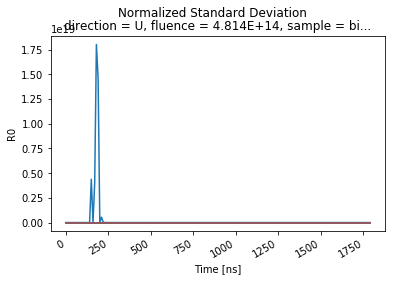

In [160]:
%matplotlib inline

g = (ds_cov_r['R0']/ds_p_r['R0']).sel(direction = 'U').dropna('fluence','all').plot(hue = 'dist', col = col)

axes = g.axes.flatten() if type(g) is xr.plot.facetgrid.FacetGrid else [g[0].axes]
fig = g.fig if type(g) is xr.plot.facetgrid.FacetGrid else g[0].figure

for ax in axes:
#     ax.set_yscale('log')
#     ax.set_ylim([-1,2])
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    
    lns = ax.lines
    for ln in lns:
        plot.dropna_ln(ln)
        
fig.suptitle('Normalized Standard Deviation')
# fig.tight_layout()
fig.autofmt_xdate()

if len(fig.legends) > 0:
    fig.legends[0].remove()
else:
    ax.get_legend().remove()

## Calculating the complex conductance 


In [161]:
F=1

ft = ds_p_r['f0']#.sel(direction =direc)
f0 = ft.isel(time = 0)
sigi = -1*(ft-f0)*e0/F
sigiu = -1*(ds_cov_r['f0'])*e0/F

# Calculate conductance from FWHM
wt = ds_p_r['w']
w0 = wt.isel(time = 0)
deltaFWHM = wt - w0
sigr = deltaFWHM*e0/(2*F)

# Calculate real conductance from deltaR/R   
# def R02cond(R0t):
#     samp = R0t.coords['sample'].values.item()
#     K = Ks[samp]
#     R0t0 = R0t.dropna('time','all').isel(time = 0)
#     cond = ((R0t-R0t0)/R0t0)/K
#     return cond

# sigr = ds_p_r['R0'].groupby('sample').apply(R02cond)

sigr.name = 'real'
sigi.name = 'im'

sigr.attrs = {'units': 'S', 'long_name': '$\Delta G_r $'}
sigi.attrs = {'units': 'S', 'long_name': '$\Delta G_i $'}

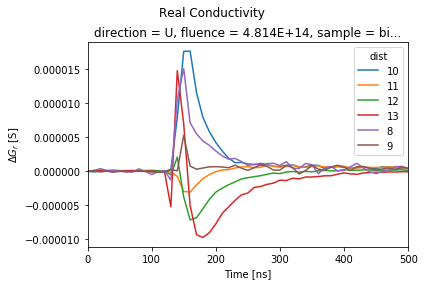

In [162]:
g = sigr.isel(sample = 0,fluence = 0).plot(x = 'time',hue = 'dist', row = row )

axes = g.axes.flatten() if type(g) is xr.plot.facetgrid.FacetGrid else [g[0].axes]
fig = g.fig if type(g) is xr.plot.facetgrid.FacetGrid else g[0].figure

for ax in axes:
#     ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
#     ax.set_ylim([1e-9,2e-6])
    lns = ax.lines
    for i, ln in enumerate(lns):
        plot.dropna_ln(ln)
        color = (0,i/len(lns),i/len(lns))
#         ln.set_color(color)
    
plt.xlim([0,500e-9])
fig.suptitle('Real Conductivity')
# fig.tight_layout()
# fig.legends[0].remove() if len(fig.legends) > 0 else ax.get_legend().remove()
fig.tight_layout(rect = [0,0,1,0.95])

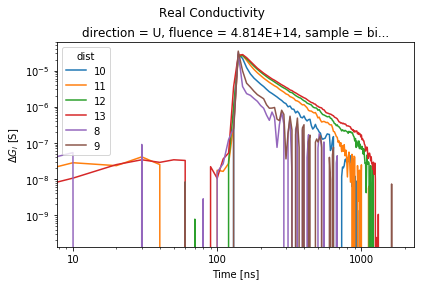

In [163]:
g = sigi.isel(sample = 0,fluence = 0).plot(x = 'time',hue = 'dist', row = row )

axes = g.axes.flatten() if type(g) is xr.plot.facetgrid.FacetGrid else [g[0].axes]
fig = g.fig if type(g) is xr.plot.facetgrid.FacetGrid else g[0].figure

for ax in axes:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
#     ax.set_ylim([1e-9,2e-6])
    lns = ax.lines
    for i, ln in enumerate(lns):
        plot.dropna_ln(ln)
        color = (0,i/len(lns),i/len(lns))
#         ln.set_color(color)
    
        
fig.suptitle('Real Conductivity')
# fig.tight_layout()
# fig.legends[0].remove() if len(fig.legends) > 0 else ax.get_legend().remove()
fig.tight_layout(rect = [0,0,1,0.95])

In [164]:
%store sigr
%store sigi

Stored 'sigr' (DataArray)
Stored 'sigi' (DataArray)


In [169]:
da  = (da_dv/da_bv)

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(-0.01, 0.01)

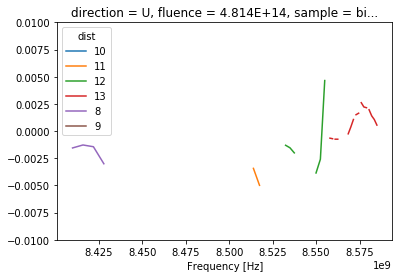

In [180]:
da.isel(sample = 0,fluence = 0,direction = 0).mean('time').plot(hue = 'dist')
plt.ylim(-0.01,0.01)

### Uncertianty calculation 